Enter your path to your .mrc directory:  /Users/roshanpathak/Documents/Research/CCC_Script/


Detected CSV file: /Users/roshanpathak/Documents/Research/CCC_Script/rename.csv
Loaded DataFrame:
                  original_filename          custom_name  threshold
0  J862_component_000_frame_000.mrc  Component 0 Frame 0      0.083
1  J862_component_000_frame_001.mrc  Component 0 Frame 1      0.083
2  J862_component_000_frame_002.mrc  Component 0 Frame 2      0.083
3  J862_component_000_frame_003.mrc  Component 0 Frame 3      0.083
4  J862_component_000_frame_004.mrc  Component 0 Frame 4      0.083
Loaded name mapping: {'J862_component_000_frame_000.mrc': 'Component 0 Frame 0', 'J862_component_000_frame_001.mrc': 'Component 0 Frame 1', 'J862_component_000_frame_002.mrc': 'Component 0 Frame 2', 'J862_component_000_frame_003.mrc': 'Component 0 Frame 3', 'J862_component_000_frame_004.mrc': 'Component 0 Frame 4', 'J862_component_000_frame_005.mrc': 'Component 0 Frame 5', 'J862_component_000_frame_006.mrc': 'Component 0 Frame 6', 'J862_component_000_frame_007.mrc': 'Component 0 Frame 7', 

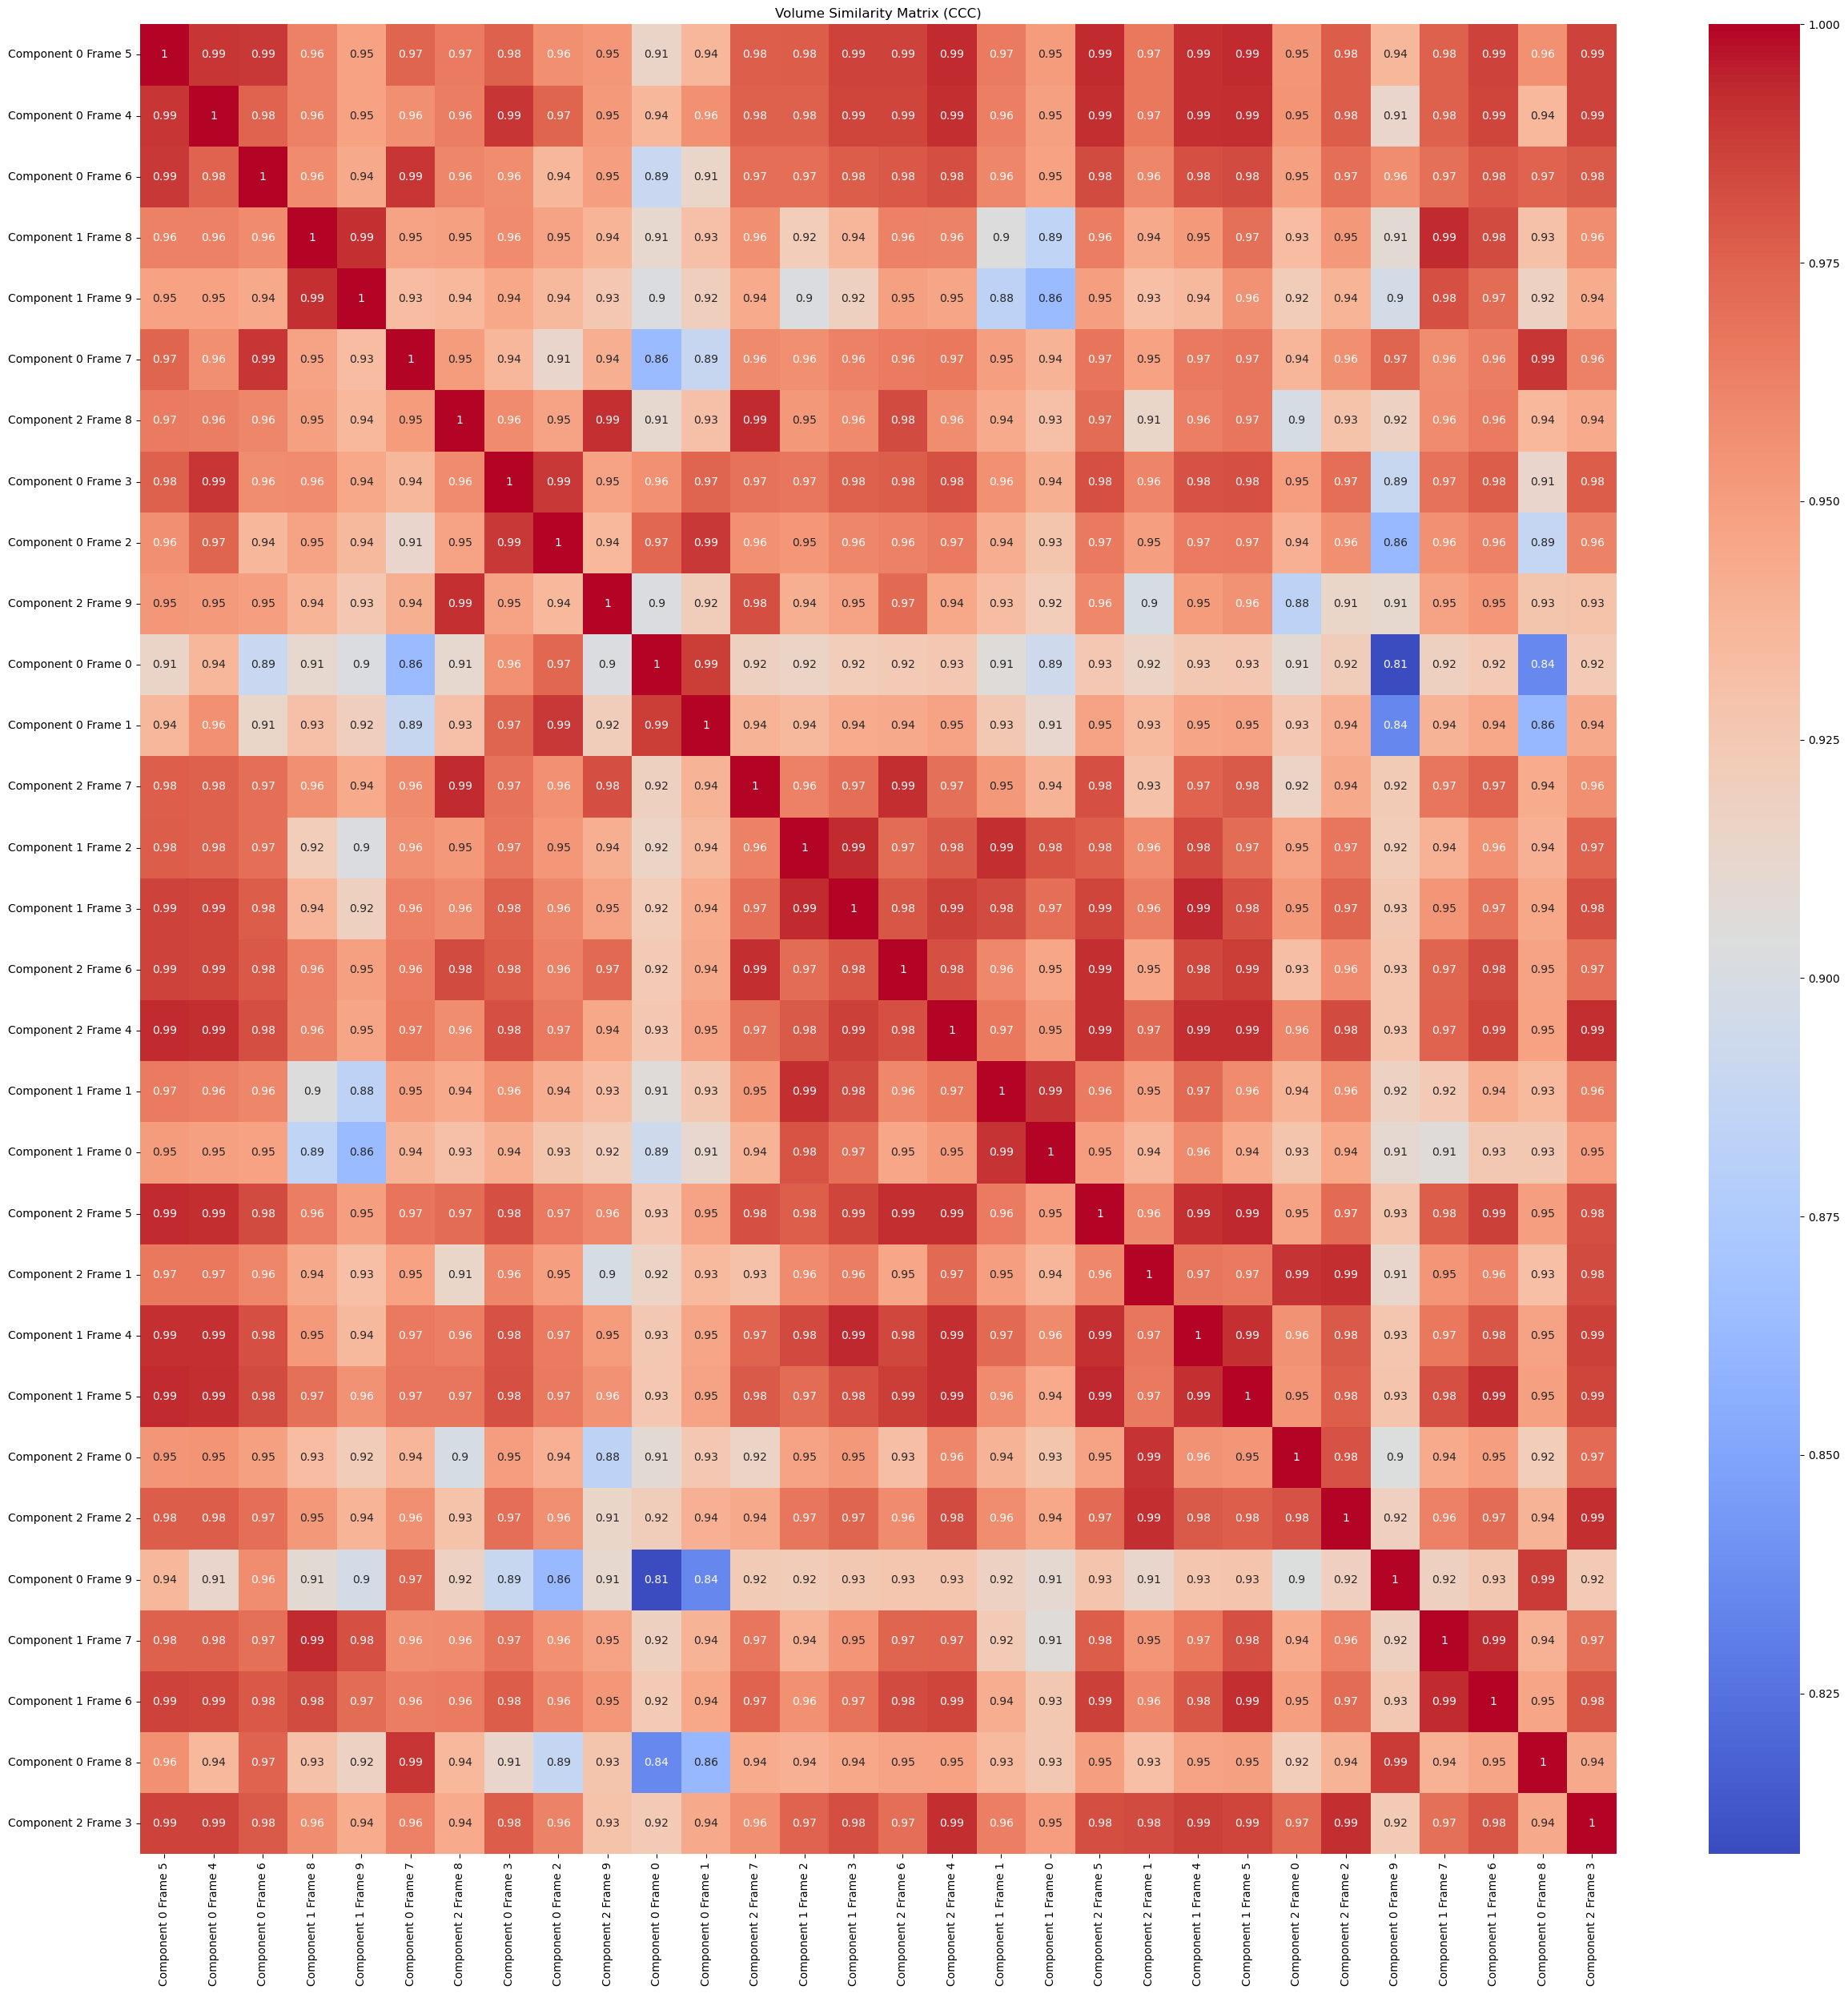

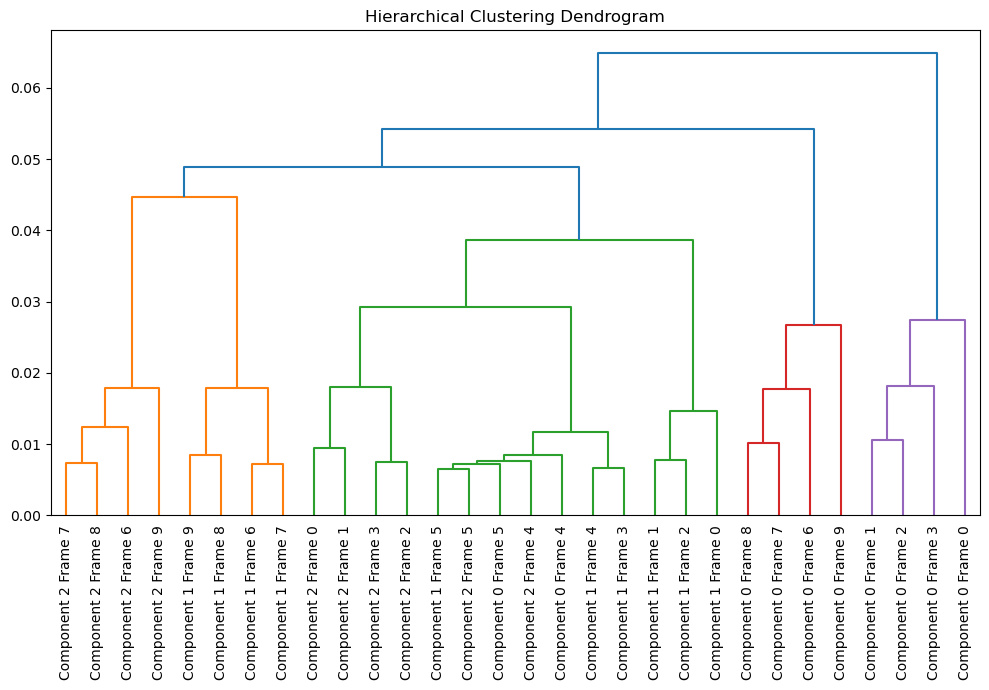

Enter the number of clusters for K-means:  4


If you formatted your .csv file correctly, then the two numbers below should be equal.
If not, make sure your csv file is formatted according to the example!
Sanity check, length of custom_names: 30
Sanity check, length of cluster_labels: 30
Cluster labels: [0 0 0 1 1 3 0 0 1 3 2 2 0 0 0 0 0 1 1 0 1 0 0 1 0 3 0 0 3 0]
Centroids: [[0.01523934 0.01568676 0.02311752 0.04104411 0.05552499 0.03756304
  0.0358312  0.02407068 0.03898231 0.04763296 0.07757205 0.05711765
  0.0259704  0.02824943 0.02037667 0.01844162 0.01558312 0.03955885
  0.05367133 0.01458003 0.03972462 0.01581288 0.01481705 0.05193762
  0.0291214  0.07581976 0.02889012 0.01989983 0.05559649 0.02085403]
 [0.04203991 0.03996501 0.04913758 0.05625933 0.06750732 0.06187207
  0.06867946 0.042744   0.05115269 0.08050419 0.08402837 0.06595687
  0.05792993 0.04941342 0.04465611 0.04881984 0.03916979 0.05603951
  0.06690718 0.04249534 0.04253785 0.04191449 0.04102073 0.04955793
  0.03952827 0.09820105 0.04883193 0.04351647 0.07883565

In [1]:
import os
import numpy as np
import pandas as pd
import mrcfile
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
import zipfile
from scipy import ndimage
from skimage.registration import phase_cross_correlation


# Calculate the cross-correlation coefficient (CCC) between two volumes
def calculate_ccc(volume1, volume2):
    volume1 = (volume1 - np.mean(volume1)) / np.std(volume1)
    volume2 = (volume2 - np.mean(volume2)) / np.std(volume2)
    ccc = np.sum(volume1 * volume2) / np.sqrt(np.sum(volume1**2) * np.sum(volume2**2))
    return ccc

# Compute similarity matrix between a list of volumes
def compute_similarity_matrix(volumes):
    n = len(volumes)
    similarity_matrix = np.zeros((n, n))

    for i, j in itertools.combinations(range(n), 2):
        ccc = calculate_ccc(volumes[i], volumes[j])
        similarity_matrix[i, j] = ccc
        similarity_matrix[j, i] = ccc
    
    np.fill_diagonal(similarity_matrix, 1.0)
    return similarity_matrix

# Plot similarity matrix as a heatmap. This is useful if you want to decide yourself how to regroup your volume classes.
def plot_similarity_matrix(similarity_matrix, custom_names):
    plt.figure(figsize=(25, 25))
    sns.heatmap(similarity_matrix, xticklabels=custom_names, yticklabels=custom_names, annot=True, cmap="coolwarm", cbar=True)
    plt.title('Volume Similarity Matrix (CCC)')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('similarity_matrix_heatmap.png')  # Save heatmap as image
    plt.show()

# Perform hierarchical clustering and plot dendrogram
def plot_dendrogram(similarity_matrix, custom_names):
    distance_matrix = 1 - similarity_matrix
    condensed_distance_matrix = squareform(distance_matrix)
    linked = linkage(condensed_distance_matrix, method='average')

    plt.figure(figsize=(10, 7))
    dendrogram(linked, labels=custom_names, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('dendrogram.png')  # Save dendrogram as image
    plt.show()

# CSV file detection
def detect_csv_file(directory):
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            return os.path.join(directory, file)
    raise FileNotFoundError("No CSV file found in the directory.")

# Updated function to load name mapping and thresholds from CSV
def load_name_mapping_and_thresholds(csv_file):
    df = pd.read_csv(csv_file)
    print("Loaded DataFrame:")
    print(df.head())  # Display the first few rows of the DataFrame
    name_mapping = dict(zip(df['original_filename'], df['custom_name']))
    threshold_mapping = dict(zip(df['original_filename'], df['threshold']))
    return name_mapping, threshold_mapping

# Modified function to load and threshold MRC file
def load_and_threshold_mrc_file(file_path, threshold):
    with mrcfile.open(file_path, permissive=True) as mrc:
        volume = mrc.data.copy()
    # Apply threshold
    volume[volume < threshold] = 0
    return volume

# Modified function to process MRC directory with names and thresholds
def process_mrc_directory_with_names_and_thresholds(directory, name_mapping, threshold_mapping):
    mrc_file_names = [f for f in os.listdir(directory) if f.endswith('.mrc')]
    filtered_mrc_file_names = [f for f in mrc_file_names if f in name_mapping]

    volumes = [load_and_threshold_mrc_file(os.path.join(directory, f), threshold_mapping[f]) 
               for f in filtered_mrc_file_names]
    custom_names = [name_mapping[f] for f in filtered_mrc_file_names]
    
    similarity_matrix = compute_similarity_matrix(volumes)
    return similarity_matrix, custom_names

# K-means clustering function. This is a conceptual explanation of how it works: 
# https://obada-khalili.medium.com/k-means-clustering-for-dummies-3c5c8282747e
def perform_kmeans_clustering(similarity_matrix, custom_names, n_clusters, output_dir):
    # Convert similarity matrix to distance matrix
    distance_matrix = 1 - similarity_matrix  # Similarity ranges from 0 to 1 as shown in Csparc

    # Check if distance_matrix is 2D
    if distance_matrix.ndim == 1:
        distance_matrix = distance_matrix.reshape(-1, 1) #this reshapes the matrix under the condition that it is 1D

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(distance_matrix)  # Should be 2D

    # Check lengths of custom_names and cluster_labels
    print("If you formatted your .csv file correctly, then the two numbers below should be equal.\nIf not, make sure your csv file is formatted according to the example!")
    print(f"Sanity check, length of custom_names: {len(custom_names)}")
    print(f"Sanity check, length of cluster_labels: {len(cluster_labels)}")

    # Save cluster results to a CSV
    if len(custom_names) != len(cluster_labels):
        raise ValueError("Mismatch between lengths of custom_names and cluster_labels")

    cluster_df = pd.DataFrame({'Custom_Name': custom_names, 'Cluster_Label': cluster_labels})
    cluster_df.to_csv(os.path.join(output_dir, 'cluster_results.csv'), index=False)

    # Output additional information
    print("Cluster labels:", cluster_labels)
    print("Centroids:", kmeans.cluster_centers_)
    print("Cluster results saved to:", os.path.join(output_dir, 'cluster_results.csv'))

    return cluster_labels

# New function to align volumes
def align_volumes(fixed, moving):
    """Align moving volume to fixed volume using phase correlation."""
    try:
        shift, _, _ = phase_cross_correlation(fixed, moving, upsample_factor=10)
        return ndimage.shift(moving, shift)
    except Exception as e:
        print(f"Error in align_volumes: {e}")
        return moving  # Return unaligned volume if alignment fails

# Updated function to plot aFnd save 3D volume
def plot_and_save_3d_volume(volume, title, output_path):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = np.meshgrid(np.arange(volume.shape[0]),
                          np.arange(volume.shape[1]),
                          np.arange(volume.shape[2]))
    
    # Use threshold to make the plot less cluttered
    threshold = np.percentile(volume, 95)  # Adjust this value as needed
    mask = volume > threshold
    
    scatter = ax.scatter(x[mask], y[mask], z[mask], c=volume[mask], alpha=0.1, s=1, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    # Add a color bar
    plt.colorbar(scatter, ax=ax, label='Intensity')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to free up memory

# Modified function to process clusters and save 3D plots
def process_clusters_and_save_3d_plots(volumes, cluster_labels, custom_names, output_dir):
    unique_cluster_labels = np.unique(cluster_labels)
    cluster_averages = {}

    for label in unique_cluster_labels:
        cluster_indices = np.where(cluster_labels == label)[0]
        cluster_volumes = [volumes[i] for i in cluster_indices]
        
        # Align volumes to the first volume in the cluster
        reference = cluster_volumes[0]
        aligned_volumes = [reference] + [align_volumes(reference, vol) for vol in cluster_volumes[1:]]
        
        # Sum aligned volumes
        average_volume = np.sum(aligned_volumes, axis=0) / len(aligned_volumes)
        
        cluster_averages[label] = average_volume
        
        # Plot and save the 3D average volume
        output_path = os.path.join(output_dir, f'cluster_{label}_3d_average.png')
        plot_and_save_3d_volume(average_volume, f'Cluster {label} 3D Average', output_path)
        
        print(f"3D average plot for Cluster {label} saved to {output_path}")

    return cluster_averages
    
# Modified main script
if __name__ == "__main__":
    directory = input('Enter your path to your .mrc directory: ')
    csv_file = detect_csv_file(directory)
    print(f"Detected CSV file: {csv_file}")
    name_mapping, threshold_mapping = load_name_mapping_and_thresholds(csv_file)
    print(f"Loaded name mapping: {name_mapping}")
    print(f"Loaded threshold mapping: {threshold_mapping}")

    # Load all volumes with thresholds
    mrc_file_names = [f for f in os.listdir(directory) if f.endswith('.mrc') and f in name_mapping]
    volumes = [load_and_threshold_mrc_file(os.path.join(directory, f), threshold_mapping[f]) for f in mrc_file_names]
    custom_names = [name_mapping[f] for f in mrc_file_names]

    # Compute similarity matrix
    similarity_matrix = compute_similarity_matrix(volumes)
    
    # Save similarity matrix to a CSV file (optional)
    similarity_csv_path = os.path.join(directory, "similarity_matrix.csv")
    np.savetxt(similarity_csv_path, similarity_matrix, delimiter=",", fmt="%.4f")

    # Plot similarity matrix
    plot_similarity_matrix(similarity_matrix, custom_names)

    # Perform hierarchical clustering and plot dendrogram
    plot_dendrogram(similarity_matrix, custom_names)

    # Perform K-means clustering
    n_clusters = int(input("Enter the number of clusters for K-means. Suggestion: use the number of groups you determine in the hierarchical clustering diagram: "))
    output_dir = directory  # Set the output directory for saving files
    cluster_labels = perform_kmeans_clustering(similarity_matrix, custom_names, n_clusters, output_dir)

    # Process clusters and save 3D average plots
    cluster_averages = process_clusters_and_save_3d_plots(volumes, cluster_labels, custom_names, output_dir)

    print("All 3D cluster average plots have been saved in the output directory.")
    print("All done!\n(つ -‘ _ ‘- )つ(つ -‘ _ ‘- )つ(つ -‘ _ ‘- )つ")
